<a href="https://colab.research.google.com/github/BrunaFerreira/Mestrado_Inteligencia_Computacional/blob/main/Densenet_ParametrosCongelados_SGD_Mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
def resize_img (df):
  resposta = []
  for i in range (0,len(df)):
    imagem = np.pad(df[i].reshape(28,28),((2, 2), (2, 2)), 'constant', constant_values=0)
    resposta.append(imagem)
  return resposta

In [2]:
import numpy as np
#Download banco de dados
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.applications import DenseNet121
from keras.models import Model
from keras.utils import to_categorical
from keras.layers import Input,Dense, Conv2D, Dropout, Flatten, MaxPooling2D,GlobalAveragePooling2D,BatchNormalization
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import seaborn as sns

## 0. Read Dataset Mnist

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


## 0.1 Normalização de Imagens

In [4]:
# Redimensionando imagem de 28 x 28 para 32x32 (entrada mínima Densenet)
x_train = np.array(resize_img(x_train))
x_test = np.array(resize_img(x_test))

In [5]:
x_train.shape

(60000, 32, 32)

Text(0.5, 1.0, 'Number : 7')

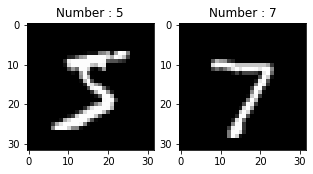

In [6]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(x_train[0,:,:], cmap='gray')
plt.title("Number : {}".format(y_train[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(x_test[0,:,:], cmap='gray')
plt.title("Number : {}".format(y_test[0]))

In [7]:
#Remodelar a matriz para 4-dim para que funcione com a API Keras
x_train = x_train.reshape(-1, 32,32, 1)
x_test = x_test.reshape(-1,32,32,1)

In [8]:
x_train = tf.convert_to_tensor(x_train)
x_train = tf.image.grayscale_to_rgb(x_train,name = None)
x_train = x_train.numpy()

In [9]:
x_test = tf.convert_to_tensor(x_test)
x_test = tf.image.grayscale_to_rgb(x_test,name = None)
x_test = x_test.numpy()

In [10]:
# Certificando-se de que os valores são flutuantes para que possamos obter pontos decimais após a divisão
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalizando os códigos RGB dividindo-os pelo valor RGB máximo.
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('Number of images in x_train', x_train.shape[0])
print('Number of images in x_test', x_test.shape[0])

x_train shape: (60000, 32, 32, 3)
Number of images in x_train 60000
Number of images in x_test 10000


In [11]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [12]:
# Change the labels from categorical to one-hot encoding
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

# Display the change for category label using one-hot encoding
print('Original label:', y_train[0])
print('After conversion to one-hot:', y_train_one_hot[0])

Original label: 5
After conversion to one-hot: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


### 0.2 Separação de dados Treino e Validação

In [13]:
train_X,valid_X,train_label,valid_label = train_test_split(x_train, y_train_one_hot, test_size=0.2, random_state=13)

print("X_Train Shape:", train_X.shape,"\nX_Valid Shape:",valid_X.shape,"\nX_Test Shape:",x_test.shape,
     "\ny_Train Shape:",train_label.shape,"\ny_Valid Shape:",valid_label.shape,"\ny_Test Shape:",y_test_one_hot.shape)

X_Train Shape: (48000, 32, 32, 3) 
X_Valid Shape: (12000, 32, 32, 3) 
X_Test Shape: (10000, 32, 32, 3) 
y_Train Shape: (48000, 10) 
y_Valid Shape: (12000, 10) 
y_Test Shape: (10000, 10)


### 1. Definindo Arquitetura da Rede Densenet - 121



In [14]:
#Parametros Iniciais
batch_size = 64
epochs = 20
num_classes = 10

In [15]:
#Arquitetura rede Densenet121
model_121 = DenseNet121(weights='imagenet',include_top=False, input_shape=(32, 32, 3)) 

29089792/29084464 [==============================] - 0s 0us/step


In [16]:
#Saida do Modelo
x=model_121.output

x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)
x= Dense(1024,activation='relu')(x) 
x= Dense(512,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.5)(x)

preds=Dense(num_classes,activation='softmax')(x) 

In [17]:
for layer in model_121.layers:
  layer.trainable = False

In [18]:
model = Model(inputs=model_121.input,outputs=preds)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 16, 16, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1/conv[0][0]                 
_______________________________________________________________________________________

In [19]:
model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 16, 16, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1/conv[0][0]                 
_______________________________________________________________________________________

In [20]:
model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,validation_split=0.2)

Epoch 1/20
600/600 [==============================] - 179s 298ms/step - loss: 0.7244 - accuracy: 0.7727 - val_loss: 0.2499 - val_accuracy: 0.9206
Epoch 2/20
600/600 [==============================] - 176s 293ms/step - loss: 0.4249 - accuracy: 0.8633 - val_loss: 0.1941 - val_accuracy: 0.9375
Epoch 3/20
600/600 [==============================] - 179s 298ms/step - loss: 0.3672 - accuracy: 0.8800 - val_loss: 0.1752 - val_accuracy: 0.9423
Epoch 4/20
600/600 [==============================] - 182s 303ms/step - loss: 0.3369 - accuracy: 0.8901 - val_loss: 0.1670 - val_accuracy: 0.9453
Epoch 5/20
600/600 [==============================] - 171s 285ms/step - loss: 0.3133 - accuracy: 0.8963 - val_loss: 0.1588 - val_accuracy: 0.9467
Epoch 6/20
600/600 [==============================] - 178s 297ms/step - loss: 0.2933 - accuracy: 0.9035 - val_loss: 0.1523 - val_accuracy: 0.9491
Epoch 7/20
600/600 [==============================] - 169s 282ms/step - loss: 0.2833 - accuracy: 0.9060 - val_loss: 0.1471 -

### **Avaliando o modelo**

In [21]:
test_eval = model.evaluate(x_test, y_test_one_hot, verbose=0)

print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.11061732470989227
Test accuracy: 0.9614999890327454


In [22]:
Ypred = model.predict(x_test)
Ypred

array([[7.7713963e-08, 1.7854032e-05, 2.0461796e-06, ..., 9.9997401e-01,
        6.3083196e-09, 5.4003248e-08],
       [3.8858511e-06, 1.2041061e-05, 9.9848527e-01, ..., 1.2092131e-05,
        1.7388922e-05, 5.1673182e-05],
       [3.7153391e-06, 9.9998248e-01, 9.7884634e-10, ..., 1.2234221e-06,
        7.8282847e-10, 4.0540571e-09],
       ...,
       [6.6027587e-06, 3.8025091e-06, 2.6859755e-06, ..., 3.7598237e-03,
        1.2501124e-04, 1.9781169e-04],
       [3.5521055e-06, 1.7003997e-06, 4.6424652e-04, ..., 4.7865633e-06,
        9.9443719e-03, 5.6512290e-06],
       [9.6350981e-05, 3.3263444e-05, 3.0102448e-03, ..., 1.2338677e-05,
        6.6177126e-05, 4.1321138e-05]], dtype=float32)

In [23]:
Ypred = np.argmax(Ypred, axis=1)
Ypred

array([7, 2, 1, ..., 4, 5, 6])

In [24]:
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [25]:
cm = confusion_matrix(y_test, Ypred)

In [26]:
cm

array([[ 966,    0,    2,    1,    1,    2,    5,    0,    1,    2],
       [   0, 1125,    1,    0,    4,    1,    2,    1,    1,    0],
       [   2,    0,  980,   14,    3,   13,    5,    9,    4,    2],
       [   0,    0,    8,  973,    0,   17,    1,    3,    5,    3],
       [   0,    1,    3,    0,  965,    0,    1,    3,    2,    7],
       [   1,    0,    7,   42,    1,  827,    2,    5,    6,    1],
       [   6,    0,    4,    4,    2,   10,  929,    0,    2,    1],
       [   0,    4,    5,    2,   45,    2,    0,  949,    0,   21],
       [   2,    0,    8,    6,    5,    6,    3,    1,  932,   11],
       [   3,    1,    6,    6,   12,    1,    1,    5,    5,  969]])

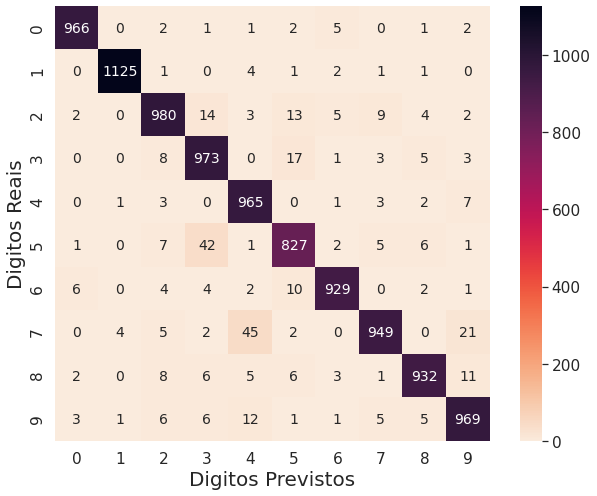

In [27]:
plt.figure(figsize=(11, 8))
sns.set(font_scale=1.4)
ax = sns.heatmap(cm,annot=True,fmt='g',annot_kws={'size':14} ,square=True,cmap='rocket_r')
ax.set_ylabel('Digitos Reais', fontsize=20)
ax.set_xlabel('Digitos Previstos', fontsize=20)
plt.show()

In [28]:
cm

array([[ 966,    0,    2,    1,    1,    2,    5,    0,    1,    2],
       [   0, 1125,    1,    0,    4,    1,    2,    1,    1,    0],
       [   2,    0,  980,   14,    3,   13,    5,    9,    4,    2],
       [   0,    0,    8,  973,    0,   17,    1,    3,    5,    3],
       [   0,    1,    3,    0,  965,    0,    1,    3,    2,    7],
       [   1,    0,    7,   42,    1,  827,    2,    5,    6,    1],
       [   6,    0,    4,    4,    2,   10,  929,    0,    2,    1],
       [   0,    4,    5,    2,   45,    2,    0,  949,    0,   21],
       [   2,    0,    8,    6,    5,    6,    3,    1,  932,   11],
       [   3,    1,    6,    6,   12,    1,    1,    5,    5,  969]])

9


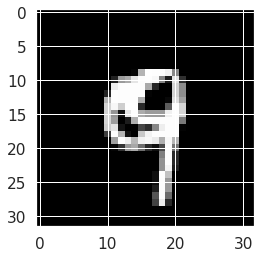

In [29]:
image_index = 4444
plt.imshow(x_test[image_index],cmap='Greys')
pred = model.predict(x_test[image_index].reshape(1, 32, 32, 3))
print(pred.argmax())